In [2]:
# install dependencies
# %pip install PyQt5 pyqtgraph

from abc import ABC, abstractmethod
import math as m
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sympy as sym

from typing import Iterable
import pyqtgraph as pg
from pyqtgraph.Qt import QtCore

In [3]:
class Solution(ABC):
    @abstractmethod
    def load_file(self, file_path) -> None:
        pass

    @abstractmethod
    def solve(self, save_results=True, **kwargs) -> None:
        pass

    @abstractmethod
    def plot(self, **kwargs) -> None:
        pass

In [4]:
class Animation:
    def __init__(self, landmarks: Iterable[float]) -> None:
        # window
        self.win = pg.plot(show=True)
        self.win.resize(800, 600)
        self.win.setWindowTitle("Animation Ex03")
        self.win.setBackground("w")
        self.win.setAspectLocked(lock=True, ratio=1)
        self.win.getViewBox().wheelEvent = lambda event: None
        self.win.setXRange(-2, 10)
        self.win.setYRange(-3, 4)

        # colors
        color_landmarks = pg.mkColor(10, 10, 10)  # black
        color_landmarks.setAlpha(255)

        color_pos_true = pg.mkColor(0, 114, 189)  # blue
        color_pos_true.setAlpha(220)

        color_traj_true = pg.mkColor(0 * 0.1, 114 * 0.1, 189 * 0.1)  # blue
        color_traj_true.setAlpha(1)

        color_pos_est = pg.mkColor(252, 41, 30)  # red
        color_pos_est.setAlpha(220)

        color_traj_est = pg.mkColor(252 * 0.1, 41 * 0.1, 30 * 0.1)  # red
        color_traj_est.setAlpha(1)

        color_ellipse = pg.mkColor(252, 41, 30)  # red
        color_ellipse.setAlpha(60)

        # landmarks
        self.landmarks = pg.ScatterPlotItem()
        self.landmarks.setPen(color_landmarks)
        self.landmarks.setBrush(color_landmarks)
        self.landmarks.setData(x=landmarks[:, 0], y=landmarks[:, 1])

        # true position
        self.pos_true = pg.ScatterPlotItem()
        self.pos_true.setSize(5)
        self.pos_true.setPen(color_pos_true)
        self.pos_true.setBrush(color_pos_true)

        # true trajectory
        self.traj_true = pg.ScatterPlotItem()
        self.traj_true.setSize(1)
        self.traj_true.setPen(color_pos_true)
        self.traj_true.setBrush(color_pos_true)
        self.traj_true_data = [[], []]

        # estimated position
        self.pos_est = pg.ScatterPlotItem()
        self.pos_est.setSize(5)
        self.pos_est.setPen(color_pos_est)
        self.pos_est.setBrush(color_pos_est)

        # estimated trajectory
        self.traj_est = pg.ScatterPlotItem()
        self.traj_est.setSize(1)
        self.traj_est.setPen(color_pos_est)
        self.traj_est.setBrush(color_pos_est)
        self.traj_est_data = [[], []]

        # uncertainty ellipse
        self.ellipse = pg.PlotCurveItem()
        self.ellipse.setPen(color_ellipse, width=4)
        self.ellipse.setBrush(color_ellipse)
        self.ellipse.setFillLevel(0)

        # legend
        self.legend = pg.LegendItem()
        self.legend.setParentItem(self.win.graphicsItem())
        self.legend.setOffset((20, 1))
        self.legend.addItem(self.landmarks, "Landmarks")
        self.legend.addItem(self.pos_true, "True position")
        self.legend.addItem(self.pos_est, "Estimated position")
        self.legend.addItem(self.ellipse, "Uncertainty ellipse")

        self.win.addItem(self.landmarks)
        self.win.addItem(self.pos_true)
        self.win.addItem(self.pos_est)
        self.win.addItem(self.ellipse)
        self.win.addItem(self.traj_true)
        self.win.addItem(self.traj_est)

    def compute_ellipse(
        self, mean: Iterable[float], covariance: Iterable[float]
    ) -> Iterable[float]:
        M = 6 # 6 sigma

        eigenvalues, eigenvectors = np.linalg.eigh(covariance)
        order = eigenvalues.argsort()[::-1]
        eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]

        # Get the index of the largest eigenvector
        lamda1 = eigenvalues.max()
        lamda2 = eigenvalues.min()
        largest_eigenvec_idx = eigenvalues.argmax()
        largest_eigenvec = eigenvectors[:, largest_eigenvec_idx]

        # Calculate the angle of the ellipse
        angle = np.arctan2(largest_eigenvec[1], largest_eigenvec[0])

        # Full ellipse around zero
        theta = np.linspace(0, 2 * np.pi, 50)
        x = M * np.sqrt(lamda1) * np.cos(theta)
        y = M * np.sqrt(lamda2) * np.sin(theta)

        sin_th = np.sin(angle).item()
        cos_th = np.cos(angle).item()
        rot_mat = np.array([[cos_th, -sin_th], [sin_th, cos_th]])

        ellipse = np.array([x, y])
        ellipse = rot_mat @ ellipse

        # Shift the ellipse to the mean
        ellipse[0] += mean[0]
        ellipse[1] += mean[1]

        return ellipse

    def update(
        self,
        mean: Iterable[float],
        covariance: Iterable[float],
        true_position=None,
        plot_est_trajectory=True,
        plot_true_trajectory=True,
    ) -> None:
        self.pos_est.setData([mean[0]], [mean[1]])
        if plot_est_trajectory:
            self.traj_est_data[0].append(mean[0])
            self.traj_est_data[1].append(mean[1])
            self.traj_est.setData(self.traj_est_data[0], self.traj_est_data[1])

        if true_position is not None:
            self.pos_true.setData([true_position[0]], [true_position[1]])
            if plot_true_trajectory:
                self.traj_true_data[0].append(true_position[0])
                self.traj_true_data[1].append(true_position[1])
                self.traj_true.setData(self.traj_true_data[0], self.traj_true_data[1])

        if covariance is not None:
            ellipse = self.compute_ellipse(mean, covariance)
            self.ellipse.setData(ellipse[0], ellipse[1])

In [5]:
class Sensor:
    def __init__(self, load_file):
        mat = sp.io.loadmat(load_file)

        # ground truth
        t = mat["t"]
        x_true = mat["x_true"]
        y_true = mat["y_true"]
        th_true = mat["th_true"]
        true_valid = mat["true_valid"]
        l = mat["l"]
        d = mat["d"]

        # mesaurements
        r = mat["r"]
        r_var = mat["r_var"]
        b = mat["b"]
        b_var = mat["b_var"]
        v = mat["v"]
        v_var = mat["v_var"]
        om = mat["om"]
        om_var = mat["om_var"]

        self.t = t.reshape(-1)
        self.n_samples = len(t)
        self.X_true = np.hstack((x_true, y_true, th_true))
        self.Y = np.zeros((self.n_samples, l.shape[0], 2))
        self.Y[:, :, 0], self.Y[:, :, 1] = r, b
        self.u = np.hstack((v, om))
        self.params = {
            "l": l,
            "d": d.item(),
            "Q": np.diag([v_var.item(), om_var.item()]),
            "R": np.diag([r_var.item(), b_var.item()]),
        }
        self.k = 0

    def get_params(self, key):
        if key not in self.params:
            raise ValueError(f"key {key} is not in params")
        return self.params[key]

    def step(self) -> bool:
        if self.k < self.n_samples - 1:
            self.k += 1
            return True
        else:
            return False

    def get_time(self):
        return self.t[self.k]

    def get_X_k_true(self):
        return self.X_true[self.k]

    def get_u_k(self):
        return self.u[self.k]

    def get_Y_k(self):
        return self.Y[self.k]

In [6]:
class Estimator:
    def __init__(self, landmarks, d, dt, X_0, P_0, Q, R, r_max=100):
        self.landmarks = landmarks
        self.X_hat = X_0
        self.P_hat = P_0
        self.Q = Q
        self.R = R
        self.dt = dt
        self.d = d
        self.r_max = r_max

        self.X_check = None
        self.P_check = None

    def predict(self, u_k, X_true_k_1=None):
        # input
        v_k = u_k[0]
        om_k = u_k[1]

        # last state
        x_hat = self.X_hat[0]
        y_hat = self.X_hat[1]
        th_hat = self.X_hat[2]

        # operational point
        if X_true_k_1 is None:
            x_op = x_hat
            y_op = y_hat
            th_op = th_hat
        else:
            x_op = X_true_k_1[0]
            y_op = X_true_k_1[1]
            th_op = X_true_k_1[2]

        # compute P_check
        ## make H_k_1
        H_k_1 = np.matrix(
            [
                [1, 0, -self.dt * np.sin(th_op) * v_k],
                [0, 1, self.dt * np.cos(th_op) * v_k],
                [0, 0, 1],
            ]
        )

        ## make Q_k_prime
        J_h2w = np.matrix(
            [[self.dt * np.cos(th_op), 0], [self.dt * np.sin(th_op), 0], [0, self.dt]]
        )
        Q_k_prime = J_h2w @ self.Q @ J_h2w.T

        ## P_check
        self.P_check = H_k_1 @ self.P_hat @ H_k_1.T + Q_k_prime

        # compute X_check
        x_k_check = x_hat + self.dt * np.cos(th_hat) * v_k
        y_k_check = y_hat + self.dt * np.sin(th_hat) * v_k
        th_k_check = th_hat + self.dt * om_k
        self.X_check = np.array([x_k_check, y_k_check, th_k_check])

    def valid_landmarks(self, Y_k) -> np.ndarray:
        """
        Args:
            Y_k: 17 x 2 matrix (r, b) of range and bearing measurements
        Returns:
            valid landmark index (1d array)
        """
        is_visible = np.all(Y_k != 0, axis=1)
        is_under_threshold = Y_k[:, 0] <= self.r_max
        valid_idx = np.where(is_visible & is_under_threshold)[0]
        return valid_idx

    def correct(self, Y_k):
        """
        Args:
            Y_k: 17 x 2 matrix (r, b) of range and bearing measurements
        """
        # check valid landmarks
        valid_idx = self.valid_landmarks(Y_k)
        landmarks_valid = self.landmarks[valid_idx]
        n_valid = len(valid_idx)

        if n_valid == 0:
            self.X_hat = self.X_check
            self.P_hat = self.P_check
            return

        # compute K_k
        ## compute G_k
        x_l_vaild = landmarks_valid[:, 0]
        y_l_vaild = landmarks_valid[:, 1]

        x_k = self.X_check[0]
        y_k = self.X_check[1]
        th_k = self.X_check[2]

        ### intermediate variable
        term1 = x_l_vaild - x_k - self.d * np.cos(th_k)
        term2 = y_l_vaild - y_k - self.d * np.sin(th_k)
        term3 = term1**2 + term2**2

        ### compute G_k in a for loop
        G_k = np.zeros((n_valid * 2, 3))
        for i in range(n_valid):
            G_k[2 * i, 0] = -term1[i] / np.sqrt(term3[i])
            G_k[2 * i, 1] = -term2[i] / np.sqrt(term3[i])
            G_k[2 * i, 2] = (
                -self.d * term2[i] * np.cos(th_k) + self.d * term1[i] * np.sin(th_k)
            ) / np.sqrt(term3[i])
            G_k[2 * i + 1, 0] = term2[i] / term3[i]
            G_k[2 * i + 1, 1] = -term1[i] / term3[i]
            G_k[2 * i + 1, 2] = (
                -1
                + (-self.d * term2[i] * np.sin(th_k) - self.d * term1[i] * np.cos(th_k))
                / term3[i]
            )

        ## compute R_k_prime
        R_k_lifted = np.diag(np.tile(np.diag(self.R), n_valid))
        R_k_prime = R_k_lifted

        ## compute K_k
        K_k = (
            self.P_check @ G_k.T @ np.linalg.inv(G_k @ self.P_check @ G_k.T + R_k_prime)
        )

        # compute P_hat
        self.P_hat = (np.eye(3) - K_k @ G_k) @ self.P_check

        # compute X_hat
        ## compute Y_pred of valid landmarks
        r_pred_valid = np.sqrt(term3)

        ## compute b_pred of valid landmarks
        b_pred_valid = np.arctan2(term2, term1) - th_k
        # b_pred_valid = (
        #     np.mod(b_pred_valid + np.pi, 2 * np.pi) - np.pi
        # )  # wrap to [-pi, pi]

        ## compute Y_pred and innovation of valid landmarks: 2 n_valid x 1
        Y_pred_valid = np.vstack((r_pred_valid, b_pred_valid)).T.reshape(-1)
        Y_k_valid = Y_k[valid_idx].reshape(-1)
        innovation = Y_k_valid - Y_pred_valid
        innovation[1::2] = (
            np.mod(innovation[1::2] + np.pi, 2 * np.pi) - np.pi
        )  # wrap to [-pi, pi]

        self.X_hat = self.X_check + K_k @ innovation
        self.X_hat = np.array(self.X_hat).reshape(-1)

    def get_result(self) -> (np.ndarray, np.ndarray):
        """
        Returns:
            X_hat: 3 x 1 array of the current state estimate
            P_hat: 3 x 3 array of the current state covariance
        """
        return self.X_hat, self.P_hat

In [7]:
class Ex03(Solution):
    def __init__(self) -> None:
        self.sensor = None
        self.estimator = None
        self.animation = None

        self.r_maxs = []
        self.errors = []
        self.sigmas = []
        self.t_all = None

        self.timer = QtCore.QTimer()
        self.animation_show_tracjectory = False

    def load_file(self, file_path) -> None:
        self.sensor = Sensor(file_path)

    def solve(self, save_results=True, **kwargs) -> None:
        if "r_max" not in kwargs:
            raise ValueError("r_max is not given")
        r_max = kwargs["r_max"]
        good_X0 = self.sensor.get_X_k_true()
        bad_X0 = np.array([1, 1, 0.1])

        X0_to_use = good_X0
        if "using_bad_X0" in kwargs:
            using_bad_X0 = kwargs["using_bad_X0"]
            if using_bad_X0:
                X0_to_use = bad_X0

        linearization_with_X_true = False
        if "linearization_with_X_true" in kwargs:
            linearization_with_X_true = kwargs["linearization_with_X_true"]

        self.estimator = Estimator(
            landmarks=self.sensor.get_params("l"),
            d=self.sensor.get_params("d"),
            dt=0.1,
            X_0=X0_to_use,
            P_0=np.diag([1, 1, 0.1]),
            Q=self.sensor.get_params("Q"),
            R=self.sensor.get_params("R"),
            r_max=r_max,
        )

        # initial state
        X_true_0 = self.sensor.get_X_k_true()
        X_true_all = [[X_true_0[0]], [X_true_0[1]], [X_true_0[2]]]

        X_est_0, P_hat_0 = self.estimator.get_result()
        X_est_all = [[X_est_0[0]], [X_est_0[1]], [X_est_0[2]]]

        sigma0 = np.sqrt(P_hat_0.diagonal())
        sigma_all = [[sigma0[0]], [sigma0[1]], [sigma0[2]]]

        t_all = [self.sensor.get_time()]

        # X_true_k_1
        X_true_k_1 = self.sensor.get_X_k_true()

        for k in range(self.sensor.n_samples - 1):
            # step
            self.sensor.step()

            # get sensor data
            u_k = self.sensor.get_u_k()
            Y_k = self.sensor.get_Y_k()

            # predict
            if linearization_with_X_true:
                self.estimator.predict(u_k, X_true_k_1)
                X_true_k_1 = self.sensor.get_X_k_true()
            else:
                self.estimator.predict(u_k)

            # correct
            self.estimator.correct(Y_k)

            # get result
            X_true = self.sensor.get_X_k_true()
            X_hat, P_hat = self.estimator.get_result()

            # save result
            X_true_all[0].append(X_true[0])
            X_true_all[1].append(X_true[1])
            X_true_all[2].append(X_true[2])

            X_est_all[0].append(X_hat[0])
            X_est_all[1].append(X_hat[1])
            X_est_all[2].append(X_hat[2])

            sigma = np.sqrt(P_hat.diagonal())
            sigma_all[0].append(sigma[0, 0])
            sigma_all[1].append(sigma[0, 1])
            sigma_all[2].append(sigma[0, 2])

            t_all.append(self.sensor.get_time())

        error = np.array(X_est_all) - np.array(X_true_all)
        error[2] = (
            np.mod(error[2] + np.pi, 2 * np.pi) - np.pi
        )  # wrap error to [-pi, pi]
        sigma = np.array(sigma_all)

        if save_results:
            self.r_maxs.append(r_max)
            self.errors.append(error)
            self.sigmas.append(sigma)
            self.t_all = t_all

    def reset(self):
        self.sensor.k = 0
        self.estimator = None

    def plot(self, **kwargs) -> None:
        n_r = len(self.r_maxs)
        n_col = 3
        n_row = n_r

        fig, axs = plt.subplots(n_row, n_col, figsize=(20 * n_col, 6 * n_row))
        for i in range(n_r):
            error = self.errors[i]
            sigma = self.sigmas[i]

            params = ["x", "y", "theta"]
            units = ["m", "m", "rad"]
            lims = [(-0.15, 0.15), (-0.15, 0.15), (-0.4, 0.4)]
            for j in range(n_col):
                ax = axs[i, j]
                ax.set_title(
                    "error_{} to t, r_max = {} ".format(params[j], self.r_maxs[i])
                )
                ax.set_xlabel("time [s]")
                ax.set_ylabel("error_{} [{}]".format(params[j], units[j]))
                ax.set_ylim(lims[i])
                ax.plot(self.t_all, error[j], linewidth=1, label="error")
                ax.plot(
                    self.t_all,
                    3 * sigma[j],
                    color="red",
                    linewidth=0.5,
                    linestyle="--",
                    label="+3σ",
                )
                ax.plot(
                    self.t_all,
                    -3 * sigma[j],
                    color="red",
                    linewidth=0.5,
                    linestyle="--",
                    label="-3σ",
                )
                ax.fill_between(
                    self.t_all, 3 * sigma[j], -3 * sigma[j], color="gray", alpha=0.1
                )
                ax.legend(loc="upper right")

            fig.show()

    def update_animation(self, **kwargs) -> None:
        if not self.sensor.step():
            self.timer.stop()
            print("Finished")
            return
        self.estimator.predict(self.sensor.get_u_k())
        self.estimator.correct(self.sensor.get_Y_k())
        X_hat, P_hat = self.estimator.get_result()
        if self.animation_show_tracjectory:
            plot_est_trajectory = True
            plot_true_trajectory = True
        else:
            plot_est_trajectory = False
            plot_true_trajectory = False
        self.animation.update(
            X_hat[0:2],
            P_hat[0:2, 0:2],
            self.sensor.get_X_k_true()[0:2],
            plot_est_trajectory=plot_est_trajectory,
            plot_true_trajectory=plot_true_trajectory,
        )

    def play_animation(self, speed=1, show_tracjectory=False, **kwargs) -> None:
        if "r_max" not in kwargs:
            raise ValueError("r_max is not given")
        r_max = kwargs["r_max"]
        good_X0 = self.sensor.get_X_k_true()
        bad_X0 = np.array([1, 1, 0.1])

        X0_to_use = good_X0
        if "using_bad_X0" in kwargs:
            using_bad_X0 = kwargs["using_bad_X0"]
            if using_bad_X0:
                X0_to_use = bad_X0

        self.animation_show_tracjectory = show_tracjectory
        if self.animation_show_tracjectory:
            plot_est_trajectory = True
            plot_true_trajectory = True
        else:
            plot_est_trajectory = False
            plot_true_trajectory = False

        self.estimator = Estimator(
            landmarks=self.sensor.get_params("l"),
            d=self.sensor.get_params("d"),
            dt=0.1,
            X_0=X0_to_use,
            P_0=np.diag([1, 1, 0.1]),
            Q=self.sensor.get_params("Q"),
            R=self.sensor.get_params("R"),
            r_max=r_max,
        )

        self.animation = Animation(self.sensor.get_params("l"))

        # plot initial state
        X_hat, P_hat = self.estimator.get_result()
        self.animation.update(
            X_hat[0:2],
            P_hat[0:2, 0:2],
            self.sensor.get_X_k_true()[0:2],
            plot_est_trajectory=plot_est_trajectory,
            plot_true_trajectory=plot_true_trajectory,
        )

        # update
        self.timer.timeout.connect(self.update_animation)
        self.timer.start(int(1000 * 0.1 / speed))
        pg.exec()

/var/folders/tq/vp6by1g11w3d9p85nbjgnbyc0000gn/T/ipykernel_81090/3767585246.py:158: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


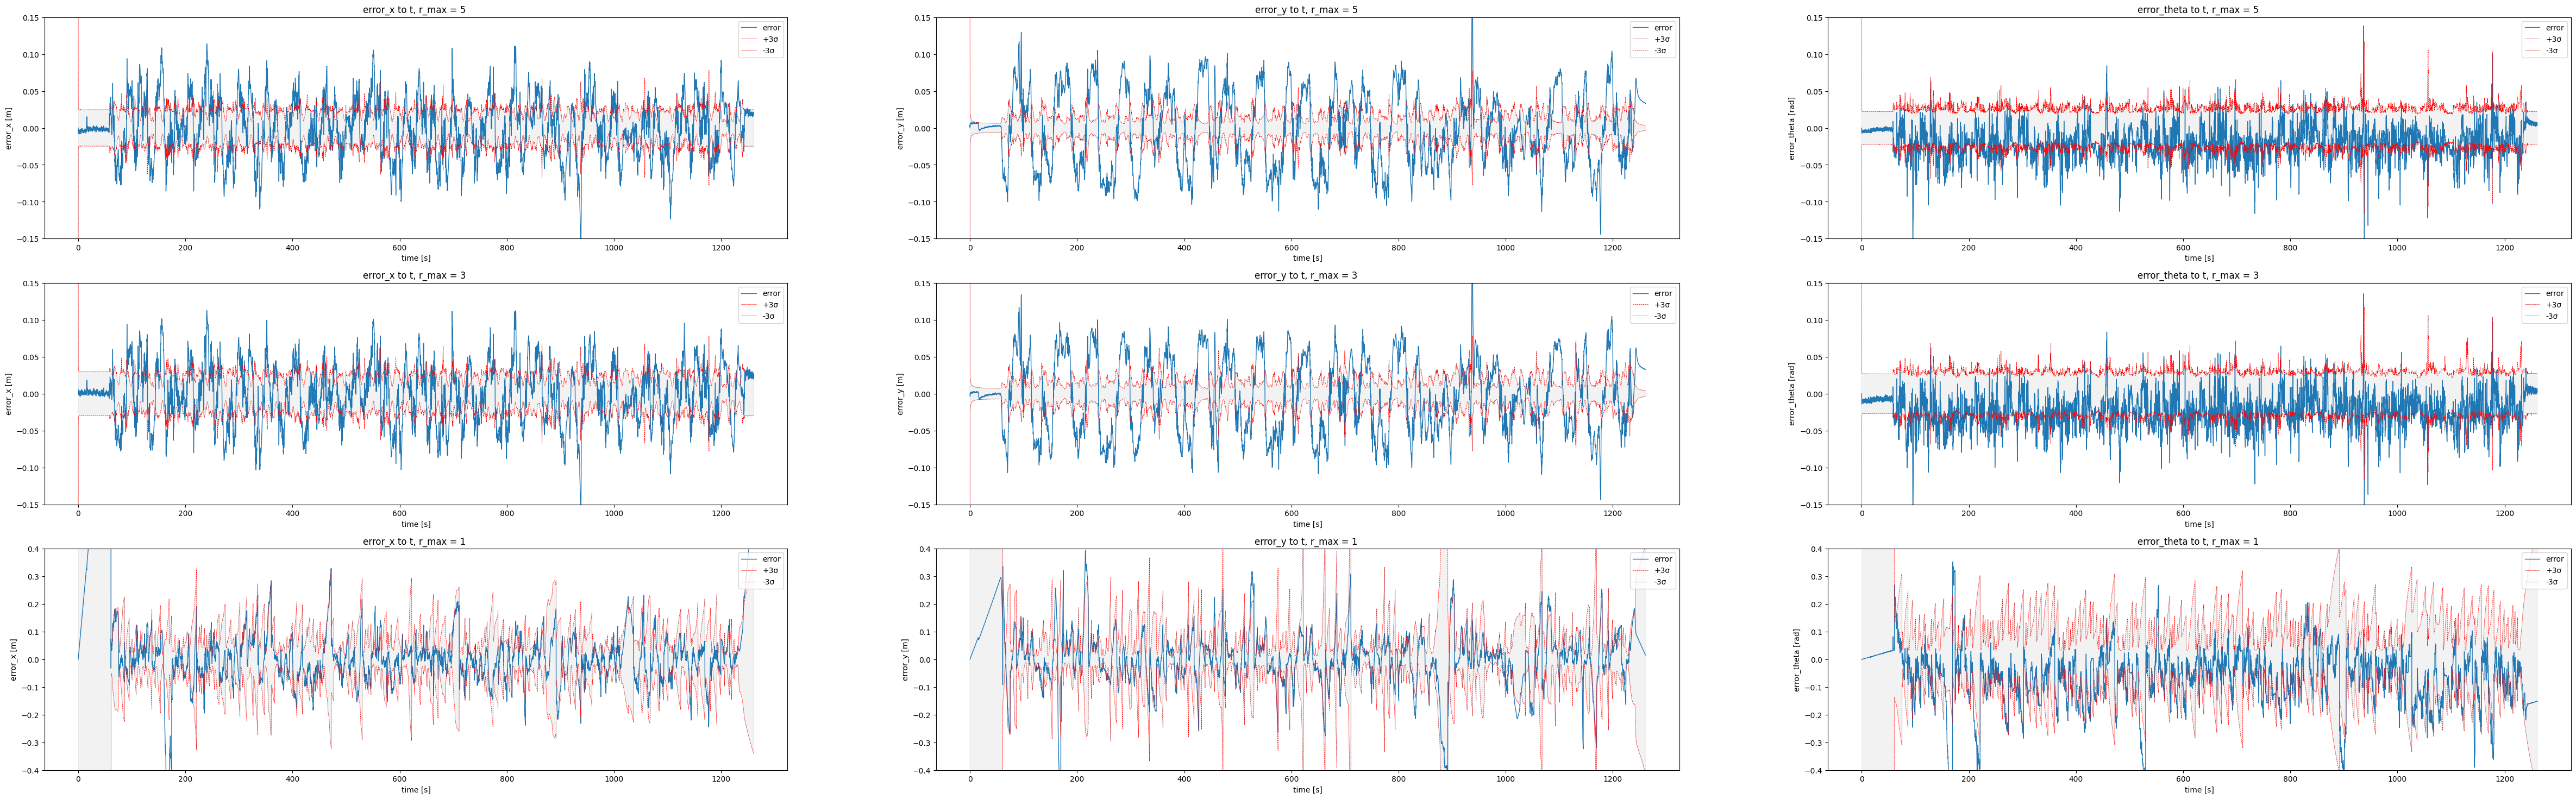

In [21]:
s3_t4a = Ex03()

s3_t4a.load_file("dataset2.mat")

s3_t4a.solve(r_max=5)
s3_t4a.reset()

s3_t4a.solve(r_max=3)
s3_t4a.reset()

s3_t4a.solve(r_max=1)
s3_t4a.reset()

s3_t4a.plot()

/var/folders/tq/vp6by1g11w3d9p85nbjgnbyc0000gn/T/ipykernel_81090/3767585246.py:158: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


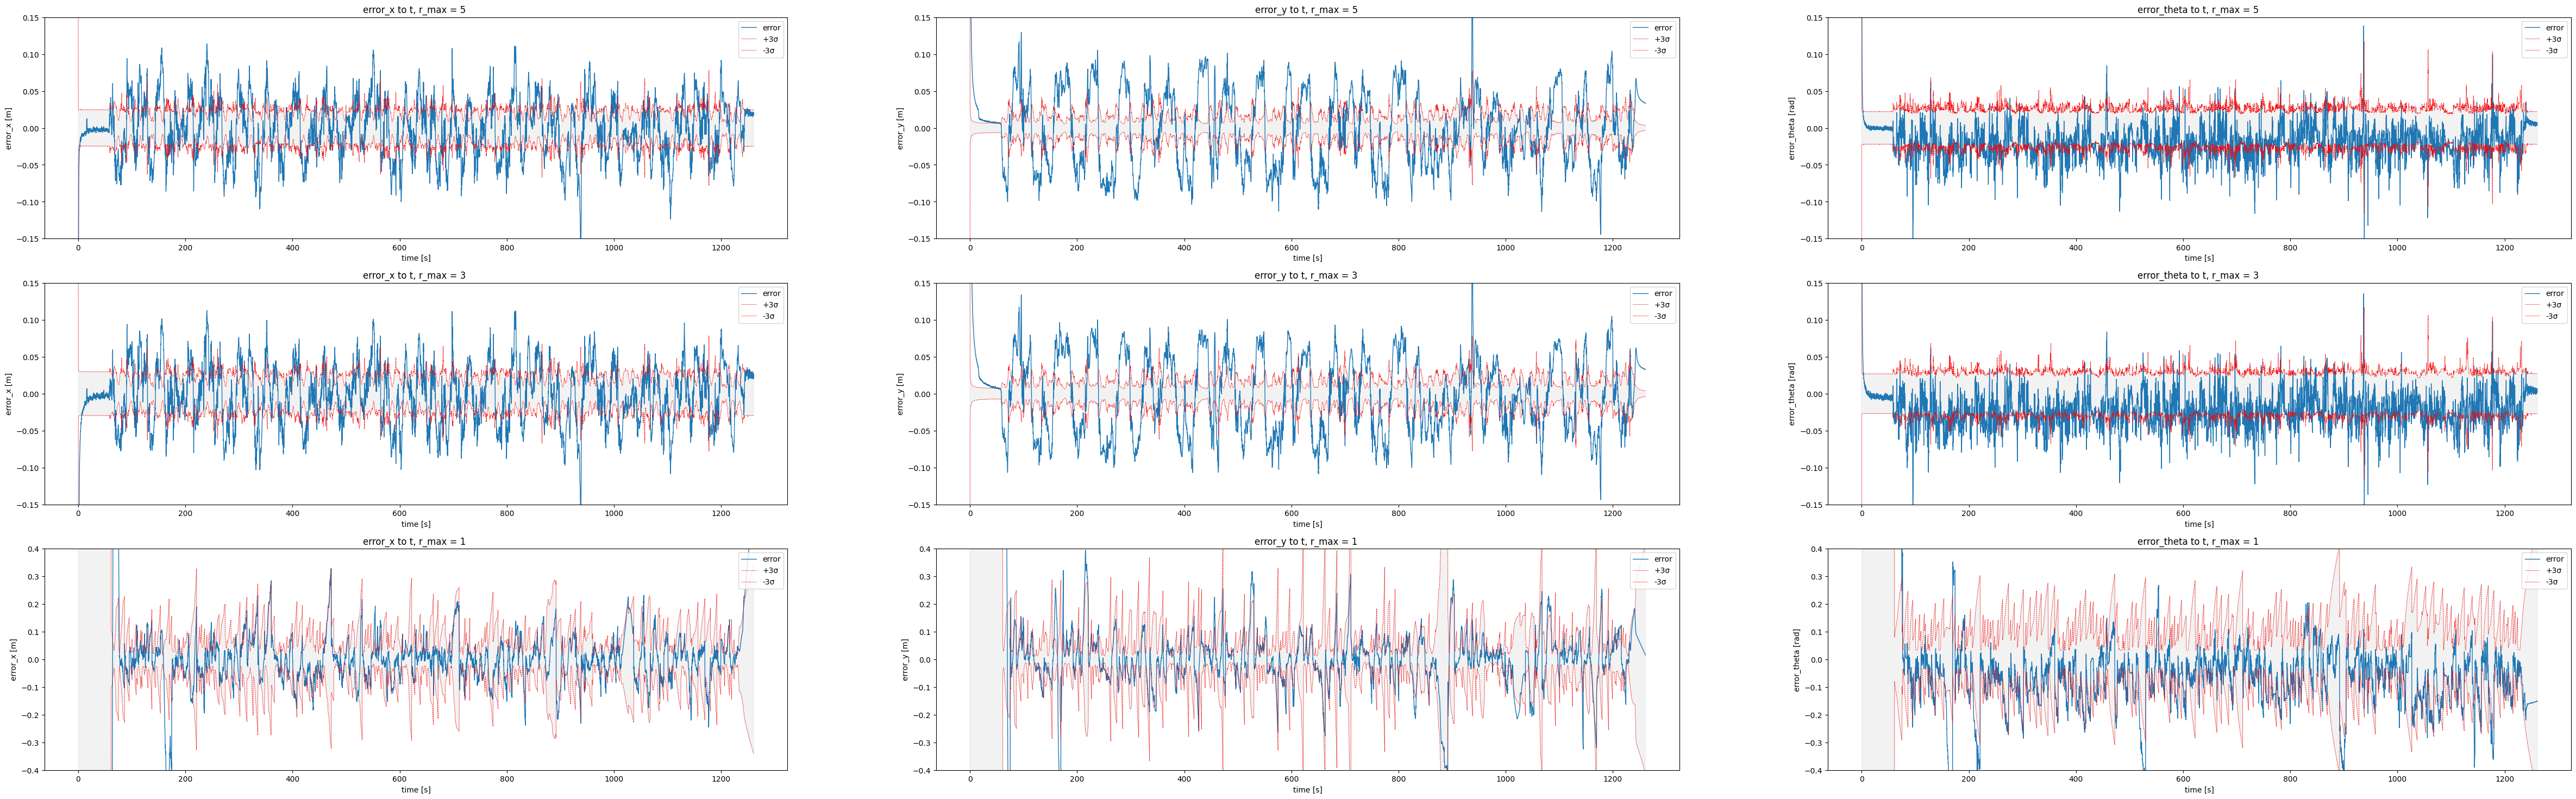

In [22]:
s3_t4b = Ex03()

s3_t4b.load_file("dataset2.mat")

s3_t4b.solve(r_max=5, using_bad_X0=True)
s3_t4b.reset()

s3_t4b.solve(r_max=3, using_bad_X0=True)
s3_t4b.reset()

s3_t4b.solve(r_max=1, using_bad_X0=True)
s3_t4b.reset()

s3_t4b.plot()

/var/folders/tq/vp6by1g11w3d9p85nbjgnbyc0000gn/T/ipykernel_81090/3767585246.py:158: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


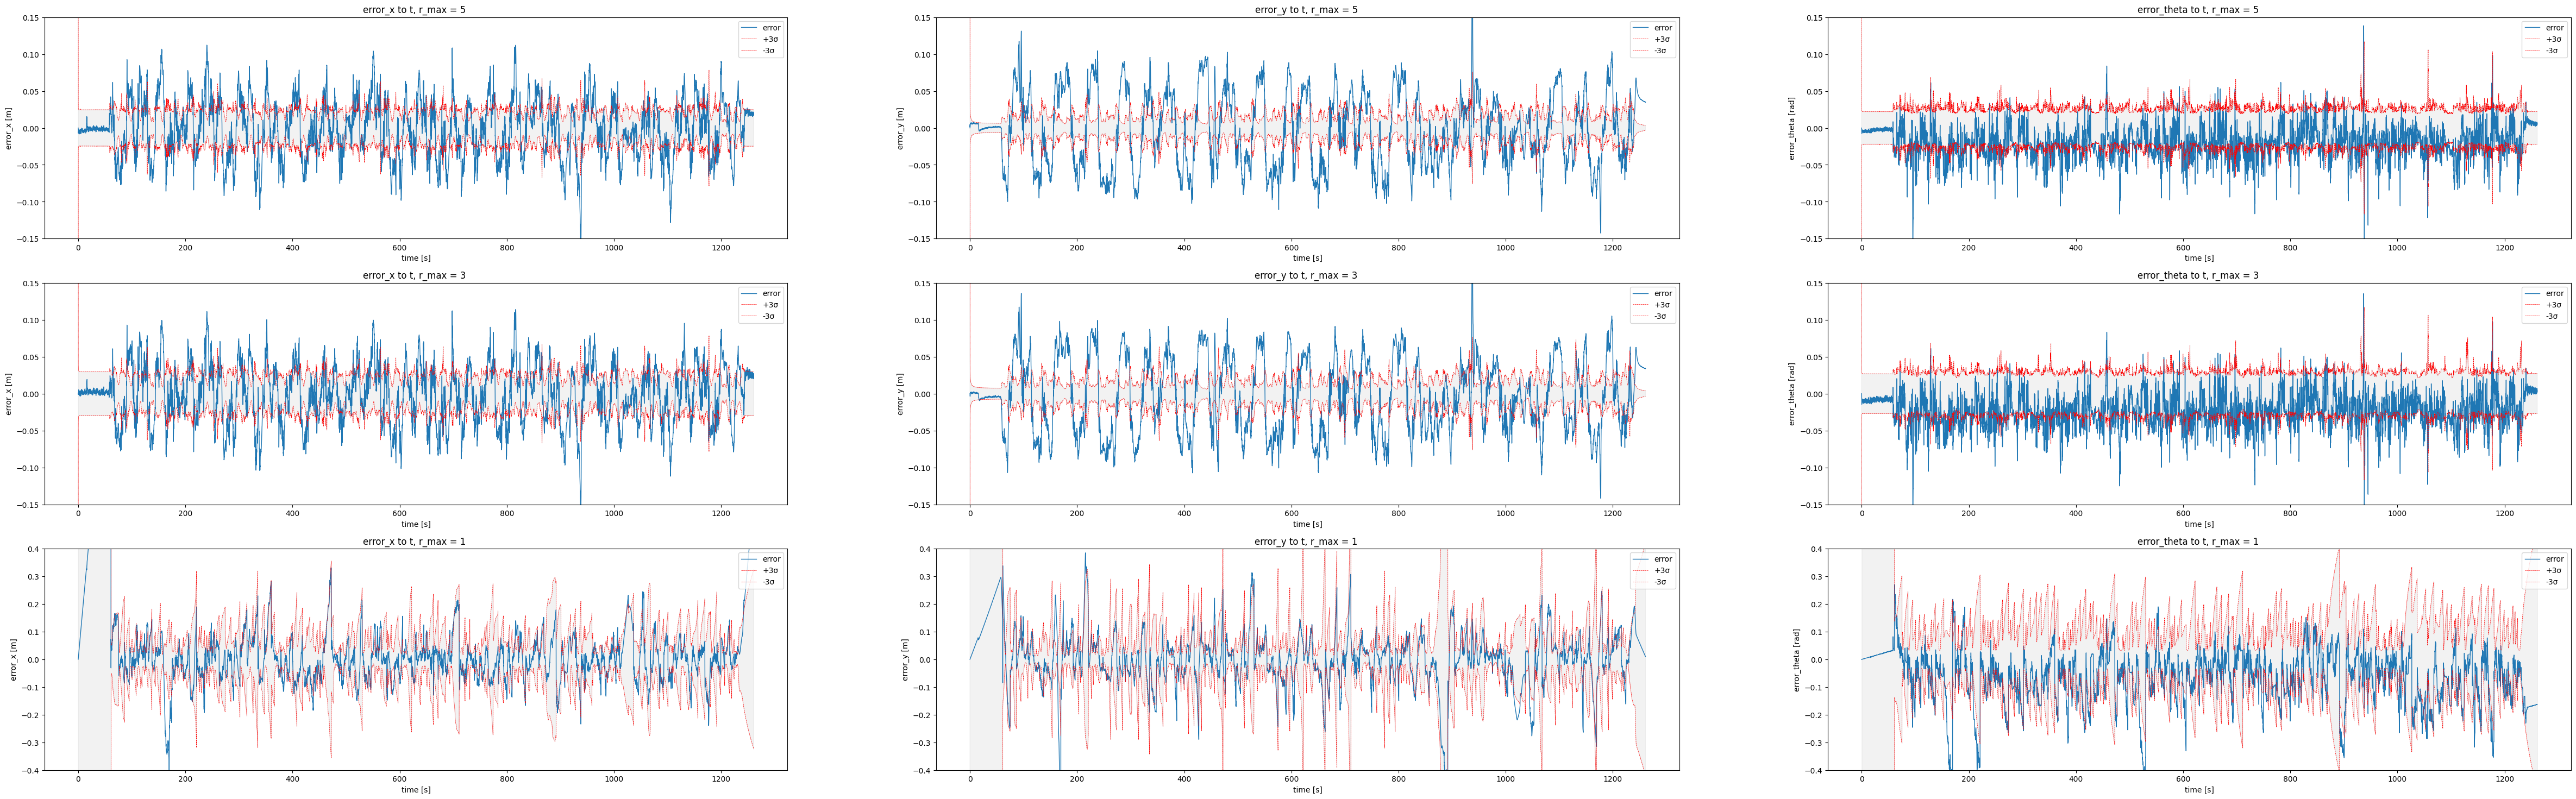

In [23]:
s3_t4c = Ex03()

s3_t4c.load_file("dataset2.mat")

s3_t4c.solve(r_max=5, using_bad_X0=False, linearization_with_X_true=True)
s3_t4c.reset()

s3_t4c.solve(r_max=3, using_bad_X0=False, linearization_with_X_true=True)
s3_t4c.reset()

s3_t4c.solve(r_max=1, using_bad_X0=False, linearization_with_X_true=True)
s3_t4c.reset()

s3_t4c.plot()

In [9]:
s3_t5 = Ex03()

s3_t5.load_file("dataset2.mat")
s3_t5.play_animation(speed=10, r_max=1, show_tracjectory=False, using_bad_X0=False)

In [ ]:
# # task 5
# speed = 10
# r_max = 1

# sensor = Sensor(load_file="dataset2.mat")

# good_X0 = sensor.get_X_k_true()
# bad_X0 = np.array([1, 1, 0.1])

# estimator = Estimator(
#     landmarks=sensor.get_params("l"),
#     d=sensor.get_params("d"),
#     dt=0.1,
#     X_0=good_X0,
#     P_0=np.diag([1, 1, 0.1]),
#     Q=sensor.get_params("Q"),
#     R=sensor.get_params("R"),
#     r_max=r_max,
# )

# animation = Animation(landmarks=sensor.get_params("l"))


# def update():
#     global animation, sensor, estimator, timer
#     if not sensor.step():
#         timer.stop()
#         print("Finished")
#         return
#     estimator.predict(sensor.get_u_k())
#     estimator.correct(sensor.get_Y_k())
#     X_hat, P_hat = estimator.get_result()
#     animation.update(
#         X_hat[0:2],
#         P_hat[0:2, 0:2],
#         sensor.get_X_k_true()[0:2],
#         plot_est_trajectory=True,
#         plot_true_trajectory=True,
#     )


# # plot initial state
# X_hat, P_hat = estimator.get_result()
# animation.update(X_hat[0:2], P_hat[0:2, 0:2], sensor.get_X_k_true()[0:2])

# timer = QtCore.QTimer()
# timer.timeout.connect(update)
# timer.start(int(1000 * 0.1 / speed))
# pg.exec()

In [ ]:
# # load data
# mat = sp.io.loadmat("dataset2.mat")
# mat.keys()
# # '__header__', '__version__', '__globals__',
# # 't', 'r', 'b', 'v', 'om', 'l', 'x_true', 'y_true', 'th_true', 'true_valid',
# # 'd', 'r_var', 'b_var', 'v_var', 'om_var'

# # ground truth
# t = mat["t"]  # 12609 x 1
# x_true = mat["x_true"]  # 12609 x 1
# y_true = mat["y_true"]  # 12609 x 1
# th_true = mat["th_true"]  # 12609 x 1
# true_valid = mat["true_valid"]  # 12609 x 1
# landmarks = mat["l"]  # 17 x 2 matrix (x,y) of landmark locations
# dist = mat[
#     "d"
# ]  # 1 x 1 the distance between the center of the robot and the laser rangeﬁnder

# # mesaurements
# r = mat["r"]  # 12609 x 17
# r_var = mat["r_var"]  # 1 x 1
# b = mat["b"]  # 12609 × 17 array containing the bearing
# b_var = mat["b_var"]  # 1 x 1
# v = mat["v"]  # 12609 × 1 array containing the translational speed
# v_var = mat["v_var"]  # 1 x 1
# om = mat["om"]  # 12609 × 1 array containing the rotational speed omega
# om_var = mat["om_var"]  # 1 x 1

In [ ]:
# n_samples = t.shape[0]
# n_landmarks = landmarks.shape[0]

# X_true = np.hstack((x_true, y_true, th_true))

# u = np.hstack((v, om))

# Y_true = np.zeros((n_samples, n_landmarks, 2))
# Y_true[:, :, 0] = r
# Y_true[:, :, 1] = b

# Q = np.diag(
#     [
#         v_var.item(),
#         om_var.item(),
#     ]
# )
# R = np.diag([r_var.item(), b_var.item()])
# T = 0.1
# d = dist.item()

# # initial state
# X_0 = X_true[0]
# P_0 = np.diag([1, 1, 0.1])

# X_hat = X_0
# P_hat = P_0

# # input

# # k = np.random.randint(0, 12609)
# # l = np.random.randint(0, 17)

# k = 1
# r_max = 3  # 5, 3, 1

# # check valid landmark
# Y_k = Y_true[k]
# is_visible = np.all(Y_k != 0, axis=1)
# is_under_threshold = Y_k[:, 0] <= r_max
# valid_idx = np.where(is_visible & is_under_threshold)[0]

# ## sensor reading
# u_k = u[k]

# v_k = u_k[0]
# om_k = u_k[1]

# x_hat = X_hat[0]
# y_hat = X_hat[1]
# th_hat = X_hat[2]

# ## landmark
# landmarks_valid = landmarks[valid_idx]

# # prediction

# ## H
# H = np.matrix(
#     [[1, 0, -T * np.sin(th_hat) * v_k], [0, 1, T * np.cos(th_hat) * v_k], [0, 0, 1]]
# )

# ## Q_prime
# J_h_w = np.matrix([[T * np.cos(th_hat), 0], [T * np.sin(th_hat), 0], [0, T]])
# Q_prime = J_h_w @ Q @ J_h_w.T

# ## P_check
# P_check = H @ P_hat @ H.T + Q_prime

# ## X_check
# x_k = x_hat + T * np.cos(th_hat) * v_k
# y_k = y_hat + T * np.sin(th_hat) * v_k
# th_k = th_hat + T * om_k
# X_check = np.array([x_k, y_k, th_k])

# ## G ((2 * n_valid), 3)
# landmarks_valid = landmarks[valid_idx]
# n_valid = len(valid_idx)
# G = np.zeros((n_valid * 2, 3))

# x_l_vaild = landmarks_valid[:, 0]
# y_l_vaild = landmarks_valid[:, 1]

# term1 = x_l_vaild - x_k - d * np.cos(th_k)
# term2 = y_l_vaild - y_k - d * np.sin(th_k)
# term3 = term1**2 + term2**2

# for i in range(n_valid):
#     # x_l = landmarks_valid[i, 0]
#     # y_l = landmarks_valid[i, 1]

#     # term1 = x_l - x_k - d * np.cos(th_k)
#     # term2 = y_l - y_k - d * np.sin(th_k)
#     # term3 = term1**2 + term2**2

#     G[2 * i, 0] = -term1[i] / np.sqrt(term3[i])
#     G[2 * i, 1] = -term2[i] / np.sqrt(term3[i])
#     G[2 * i, 2] = (
#         -d * term2[i] * np.cos(th_k) + d * term1[i] * np.sin(th_k)
#     ) / np.sqrt(term3[i])
#     G[2 * i + 1, 0] = term2[i] / term3[i]
#     G[2 * i + 1, 1] = -term1[i] / term3[i]
#     G[2 * i + 1, 2] = (
#         -1 + (-d * term2[i] * np.sin(th_k) - d * term1[i] * np.cos(th_k)) / term3[i]
#     )


# ## R_prime
# R_lifted = np.diag(np.tile(np.diag(R), n_valid))
# R_prime = R_lifted

# ## K
# K = P_check @ G.T @ np.linalg.inv(G @ P_check @ G.T + R_prime)

# # correction
# ## P_hat
# P_hat = (np.eye(3) - K @ G) @ P_check

# ## X_hat
# r_pred = np.sqrt(term3)

# b_pred = np.arctan2(term2, term1) - th_k
# b_pred = np.mod(b_pred + np.pi, 2 * np.pi) - np.pi  # wrap to [-pi, pi]

# Y_pred = np.vstack((r_pred, b_pred)).T.reshape(-1)
# Y_true_k_valid = Y_true[k, valid_idx].reshape(-1)

# print(K.shape, Y_true_k_valid.shape, Y_pred.shape)

# X_hat = X_check + K @ (Y_true_k_valid - Y_pred)

In [ ]:
# compute G
x_k, y_k, theta_k, x_l, y_l, d = sym.symbols("x_k y_k theta_k x_l y_l d")

# Define the observation function g(x_k, n_k^l)
g_r = sym.sqrt(
    (x_l - x_k - d * sym.cos(theta_k)) ** 2 + (y_l - y_k - d * sym.sin(theta_k)) ** 2
)
g_phi = (
    sym.atan2(y_l - y_k - d * sym.sin(theta_k), x_l - x_k - d * sym.cos(theta_k))
    - theta_k
)

# Compute the Jacobian matrix of g with respect to x_k, y_k, theta_k

J_g = [
    [sym.diff(g_r, x_k), sym.diff(g_r, y_k), sym.diff(g_r, theta_k)],
    [sym.diff(g_phi, x_k), sym.diff(g_phi, y_k), sym.diff(g_phi, theta_k)],
]

print(J_g)

[[(d*cos(theta_k) + x_k - x_l)/sqrt((-d*sin(theta_k) - y_k + y_l)**2 + (-d*cos(theta_k) - x_k + x_l)**2), (d*sin(theta_k) + y_k - y_l)/sqrt((-d*sin(theta_k) - y_k + y_l)**2 + (-d*cos(theta_k) - x_k + x_l)**2), (-d*(-d*sin(theta_k) - y_k + y_l)*cos(theta_k) + d*(-d*cos(theta_k) - x_k + x_l)*sin(theta_k))/sqrt((-d*sin(theta_k) - y_k + y_l)**2 + (-d*cos(theta_k) - x_k + x_l)**2)], [-(d*sin(theta_k) + y_k - y_l)/((-d*sin(theta_k) - y_k + y_l)**2 + (-d*cos(theta_k) - x_k + x_l)**2), -(-d*cos(theta_k) - x_k + x_l)/((-d*sin(theta_k) - y_k + y_l)**2 + (-d*cos(theta_k) - x_k + x_l)**2), d*(d*sin(theta_k) + y_k - y_l)*sin(theta_k)/((-d*sin(theta_k) - y_k + y_l)**2 + (-d*cos(theta_k) - x_k + x_l)**2) - d*(-d*cos(theta_k) - x_k + x_l)*cos(theta_k)/((-d*sin(theta_k) - y_k + y_l)**2 + (-d*cos(theta_k) - x_k + x_l)**2) - 1]]
